# Nog een keer... welke stoffen interessant?

### Via "theorie"
Kunnen nog meer correlaties vinden door vanuit ZS met correlaties buiten te werken.

Redenerend van wat er fysiek gebeurt.

* Verkeer
  + band materiaal etc?
  + 3NO + O3 → 3NO2 (`NO2`, `s_NO3NO2`,(`NO3`))
  + 3NO2 +3OH → 3HNO3
  + *TODO* hoe ging photodissociatie ding?
* Landbouw
  + HNO3 + NH3 → NH4 + NO3 (`NH4`)
  + Die boven ook relevant, [biologische processen](https://en.wikipedia.org/wiki/Nitrogen_cycle#Nitrification)
* Weer
  + Wind snelheid/richting, echter, tot nu toe niet veel gezien. (`FHVEC`)
  + Debiet, wederom weinig gezien. (par `Ql`)
  + Neerslag, deze nog nauwelijks uit de data gehaalt.
  + Woestijnstof?
  + Zonneschijn `Q` "global radiation" (`SQ`, `SP` percentage maximum.)
  + Temperatuur `TG`, `TN`, `TNH`, `TX`, `TXH`, `T10NH` van belang? gemiddelde(`TG`),
    minimum `TN` en 10cm boven grond `TN10NH`
  + Neerslag `RH` hoeveelheid, `RHX` maximum binnen uur. `DR` duratie

> De grootste massafractie in PM2.5 is tegenwoordig afkomstig van stikstof(mon)oxiden (NO) van vrachtverkeer, ozon uit fotochemische reactie en van ammoniak uit de bio-industrie: tezamen vormen deze gassen het ammoniumnitraat (NH4NO3). De chemische reactie van NO naar HNO3 verloopt volgens 3NO + O3 → 3NO2 en 3NO2 + 3OH → 3HNO3. De reactie naar NH4NO3 verloopt volgens HNO3 + NH3 → NH4NO3. 

### Via correlaties:

Gloeirest(GR,mg/l), Zwevende stof(ZS,mg/l), Particulair organisch koolstof(POC,mg/l), Totaal organisch koolstof(TOC,mg/l), Opgelost organisch koolstof(DOC,mg/l), Rest beta activiteit(RESTB,mBq/l)

## Welke locaties interesant?
Ik denk dat vooral landelijke locaties.

In [1]:
import matplotlib.pyplot as plt

import pandas as pd

def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.apply(lambda v: dates[v])

In [2]:
par_par   = ['PAR', 'EHD', 'WAARDE']
point_par = ['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD']
other_par = ['CPM', 'FHVEC', 'SQ', 'SP', 'TG', 'TN', 'T10NH', 'RH', 'RHX']

columns = ['ID'] + par_par + ['LOC', 'PLT:X', 'PLT:Y', 'DATUM', 'TIJD'] + other_par

df = pd.read_csv("../data/data_tot.csv", encoding='latin1', usecols=columns, index_col='ID', engine='c')

df.insert(0, 'DATUM:TIJD', lookup(df.DATUM + df.TIJD))
df.drop(['DATUM', 'TIJD'], axis=1, inplace=True)

/home/jasper/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
import numpy as np

def extract_1_val(series):
    """Hackish way to get data."""
    return next(iter(series)) if len(series)>0 else np.nan

def combine_interests(df, interests, cols=[],
                      val='WAARDE', moment=['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD'], de_unit=True):
    # Groupby location&time, put together the `PAR` interests at that location&time.
    gen = ([l,
            [cdf[(cdf.PAR==par) & (cdf.EHD==ehd)][val] for par,ehd in interests],
            [cdf[~cdf[col].isna()][col] for col in cols]
           ]
           for l,cdf in df.groupby(moment))

    # Shape it into a dataframe.
    data = [[*list(l), *[extract_1_val(v) for v in vs], *[extract_1_val(v) for v in cv]] for l,vs,cv in gen]
    return pd.DataFrame(data,
                        columns = moment + (interests if not de_unit else [n for n,u in interests] + cols))

TODO schrijf deze data naar disk, doe een selectie met onderstaand.

In [4]:
loc_df = pd.read_csv("../data/intermediate/loc_clustering.csv").rename({'Unnamed: 0':'loc'}, axis=1)
loc_df = loc_df.drop('loc', axis=1).set_index(['LOC', 'PLT:X', 'PLT:Y'])

In [5]:
paru =  [('ZS', 'mg/l'), ('GR','mg/l'), ('POC','mg/l'), ('DOC','mg/l'),
         ('WINDSHD', 'm/s'), ('WINDRTG', 'graad'), ('SALNTT','DIMSLS'),
         ('NO2', 'mg/l'), ('NO3', 'mg/l'), ('NH4', 'mg/l'),
         ('O2', 'mg/l'), ('P', 'mg/l'),
         ('Ql', 'l'),
        ]
pdf3 = None

try:
    pdf3 = pd.read_csv("../data/intermediate/comb_interests_1.csv")
except BaseException as derp:  # Dont have, make it.
    pdf3 = combine_interests(df, paru, cols=other_par)

    for k in ['dbscan', 'kmeans']:
        pdf3[k] = [loc_df[k][loc] for loc in zip(pdf3.LOC, pdf3['PLT:X'], pdf3['PLT:Y'])]

    pdf3.to_csv("../data/intermediate/comb_interests_1.csv"),

land = pdf3[pdf3.kmeans==0]

(None,)

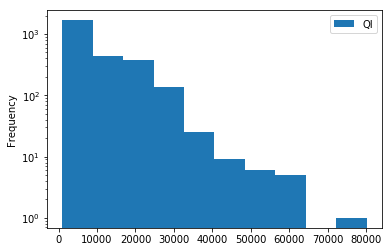

In [7]:
pdf3.plot.hist(y='Ql', logy=True)

# Niets te zien..

In [8]:
def paar_hist(land, x,y, bins=25, ax=None, title=None, logx=False, logy=False):
    if not ax:
        fig, ax = plt.subplots(figsize=(5,6))

    tmp = land[~land[x].isna() & ~land[y].isna() & (land[x]>0) & (land[y]>0)]
    ax.hist2d(np.log10(tmp[x]) if logx else tmp[x], np.log10(tmp[y]) if logy else tmp[y], bins=bins)
    if title: ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    if logx: ax.set_xticklabels([str(10**x)[:4] for x in ax.get_xticks()])
    if logy: ax.set_yticklabels([str(10**x)[:4] for x in ax.get_yticks()])

# 2D histogrammen

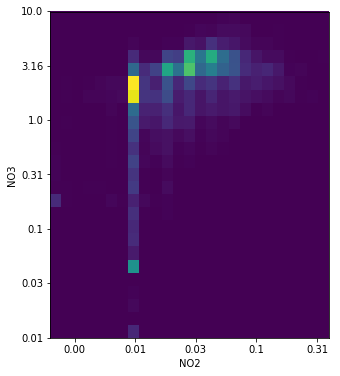

In [9]:
paar_hist(land, 'NO2', 'NO3', logx=True, logy=True)

In [10]:
import datetime, math
year_seconds = 365.25*24*3600

def year_continuous(t, t_of=False):  # time in years.
    year = t.year
    return (0 if t_of else year) + (t.timestamp() - datetime.datetime(year,1,1).timestamp())/year_seconds

def over_year(indf, name, t_of=True):
    return pd.DataFrame({'fy':[year_continuous(d, t_of) for d in indf['DATUM:TIJD']], name:list(indf[name])})

import numpy as np
def yearly_hist(indf, name, ax=None, title=None, yearly=True, bins=24):  #TODO title.
    oy = over_year(indf, name, t_of=yearly)
    oy = oy[~oy[name].isna() & ~oy.fy.isna() & (oy[name]>0)]

    if title is None:
        ax.set_title(name)

    hd = ax.hist2d(oy.fy*(12 if yearly else 1), np.log10(oy[name]), bins=bins)

    # Note y average tranforms from logirithmic and back.
    fx,tx, fy,ty= hd[3].get_extent()
    ax.plot([fx+(tx-fx)*(i+0.5)/len(hd[0]) for i in range(len(hd[0]))],
            [math.log10(sum(10**(fy+(ty-fy)*i/len(col))*n/sum(col) for i,n in enumerate(col)))
             for col in hd[0]], color='white')
    return hd

Hebben deze plots weer.

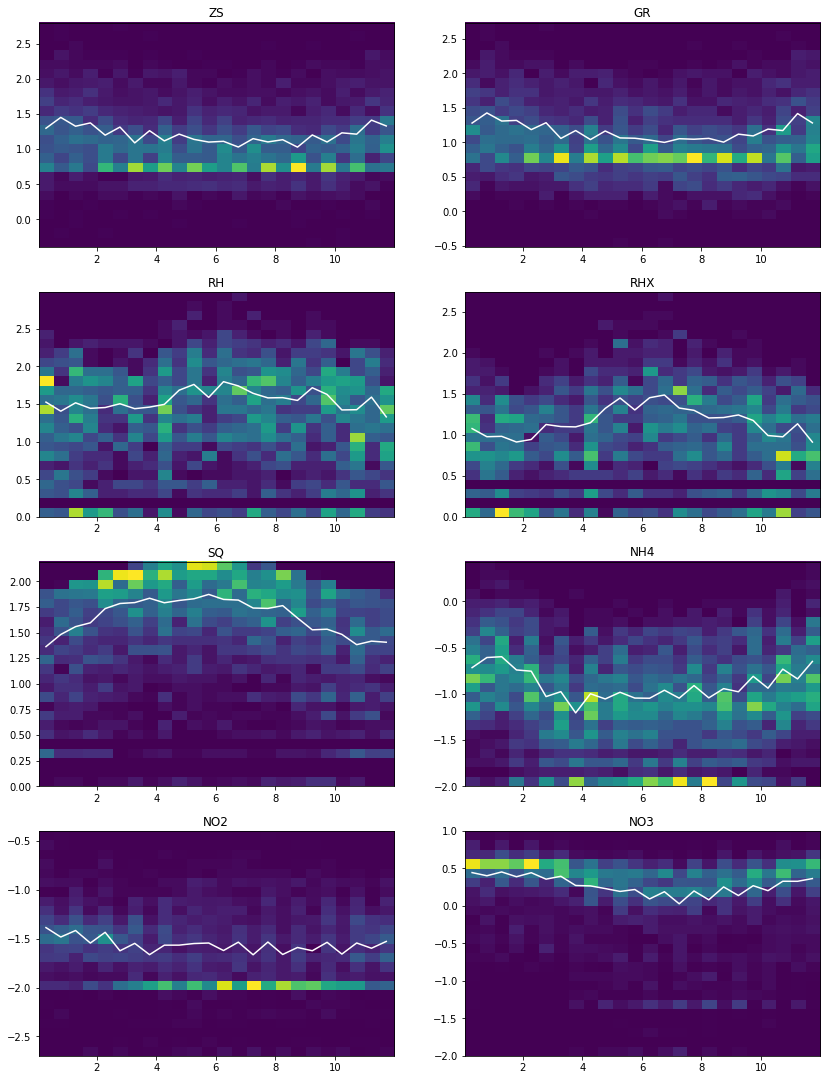

In [11]:
fig, ax = plt.subplots(4,2, figsize=(14,19))

yearly_hist(land, 'ZS', ax=ax[0][0])
yearly_hist(land, 'GR', ax=ax[0][1]) # Denk dat gewoon op die perioden meer gemeten. (en lichtelijk stof patroon)

yearly_hist(land, 'RH', ax=ax[1][0])
yearly_hist(land, 'RHX', ax=ax[1][1]) 
yearly_hist(land, 'SQ', ax=ax[2][0])
yearly_hist(land, 'NH4', ax=ax[2][1])

yearly_hist(land, 'NO2', ax=ax[3][0])
yearly_hist(land, 'NO3', ax=ax[3][1])

None

In [12]:
import numpy as np

pdf3.plot.hist('ZS')

#pdf3.plot.scatter('RHX', 'ZS', alpha=0.4, marker='.')

#fig,ax = plt.subplots(figsize=(7,7))
#ax.scatter(pdf3['RHX'], np.log10(pdf3['ZS']))
#tmp = pdf3[~pdf3['RHX'].isna() & ~pdf3['ZS'].isna()]
#ax.hist2d(tmp['RHX'], tmp['ZS'], bins=40)
#ax.set_xlabel('RHX')
#ax.set_ylabel('ZS')
#ax.loglog(True)

ValueError: view limit minimum -3100118.4 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f4235aec1e0> (for post_execute):


ValueError: view limit minimum -3100118.4 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -3100118.4 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

In [ ]:
import seaborn as sns

g = sns.PairGrid(pdf3,#[pdf3.kmeans==0],
                 vars= ['RH','RHX','ZS'], hue='kmeans')
#g.add_legend # Or something
def no_whine_hist(*l, **kv):
    try:
        return plt.hist(*l, **kv)
    except:
        return

def log_scatter(x,y, *l, **kv):
    return plt.scatter(np.log10(x), np.log10(y), *l, alpha=0.1, **kv)

g.map_diag(no_whine_hist)
g.map_lower(log_scatter)

In [ ]:
for k in land.keys():
    print(k, sum(1 for b in land[k].isna() if b))